In [26]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
from sklearn.cluster import KMeans
from shapely.geometry import Point
from rasterio.plot import show
from samgeo import overlay_images

from localtileserver import get_leaflet_tile_layer, TileClient
from ipyleaflet import Map
import leafmap
from samgeo import SamGeo, tms_to_geotiff, get_basemaps


geotiff = "../scratch/cropped_N4W351.tif"
image = rasterio.open(geotiff)

red = image.read(1).astype(float)
green = image.read(2).astype(float)
blue = image.read(3).astype(float)
nir = image.read(4).astype(float)
bands = np.dstack((red, green, blue, nir))
nbands = image.read().shape[0]
image.close()

ndvi = (nir - red) / (nir + red)
ndvi[np.isnan(ndvi)] = 0
open_spaces = ndvi >= 0.1

# NDVI/Open Spaces Mask

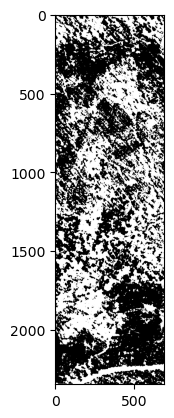

<Axes: >

In [27]:
show(open_spaces, cmap='Greys')

## Save as GeoTIFF

Credit: https://samgeo.gishub.org/

Source: https://github.com/opengeos/segment-geospatial/blob/4d1b12ec4c8a0a5d164bcb94a697c9af2dbcdecb/samgeo/common.py#L1417

In [28]:
def array_to_image(
    array, output, source=None, dtype=None, compress="deflate", **kwargs
):
    """Save a NumPy array as a GeoTIFF using the projection information from an existing GeoTIFF file.

    Args:
        array (np.ndarray): The NumPy array to be saved as a GeoTIFF.
        output (str): The path to the output image.
        source (str, optional): The path to an existing GeoTIFF file with map projection information. Defaults to None.
        dtype (np.dtype, optional): The data type of the output array. Defaults to None.
        compress (str, optional): The compression method. Can be one of the following: "deflate", "lzw", "packbits", "jpeg". Defaults to "deflate".
    """

    from PIL import Image

    if isinstance(array, str) and os.path.exists(array):
        array = cv2.imread(array)
        array = cv2.cvtColor(array, cv2.COLOR_BGR2RGB)

    if output.endswith(".tif") and source is not None:
        with rasterio.open(source) as src:
            crs = src.crs
            transform = src.transform
            if compress is None:
                compress = src.compression

        # Determine the minimum and maximum values in the array

        min_value = np.min(array)
        max_value = np.max(array)

        if dtype is None:
            # Determine the best dtype for the array
            if min_value >= 0 and max_value <= 1:
                dtype = np.float32
            elif min_value >= 0 and max_value <= 255:
                dtype = np.uint8
            elif min_value >= -128 and max_value <= 127:
                dtype = np.int8
            elif min_value >= 0 and max_value <= 65535:
                dtype = np.uint16
            elif min_value >= -32768 and max_value <= 32767:
                dtype = np.int16
            else:
                dtype = np.float64

        # Convert the array to the best dtype
        array = array.astype(dtype)

        # Define the GeoTIFF metadata
        if array.ndim == 2:
            metadata = {
                "driver": "GTiff",
                "height": array.shape[0],
                "width": array.shape[1],
                "count": 1,
                "dtype": array.dtype,
                "crs": crs,
                "transform": transform,
            }
        elif array.ndim == 3:
            metadata = {
                "driver": "GTiff",
                "height": array.shape[0],
                "width": array.shape[1],
                "count": array.shape[2],
                "dtype": array.dtype,
                "crs": crs,
                "transform": transform,
            }

        if compress is not None:
            metadata["compress"] = compress
        else:
            raise ValueError("Array must be 2D or 3D.")

        # Create a new GeoTIFF file and write the array to it
        with rasterio.open(output, "w", **metadata) as dst:
            if array.ndim == 2:
                dst.write(array, 1)
            elif array.ndim == 3:
                for i in range(array.shape[2]):
                    dst.write(array[:, :, i], i + 1)

    else:
        img = Image.fromarray(array)
        img.save(output, **kwargs)

In [29]:
mask_output = "ndvi-open-spaces.tif"
array_to_image(open_spaces, mask_output, source=geotiff)

## Kmeans Clustering

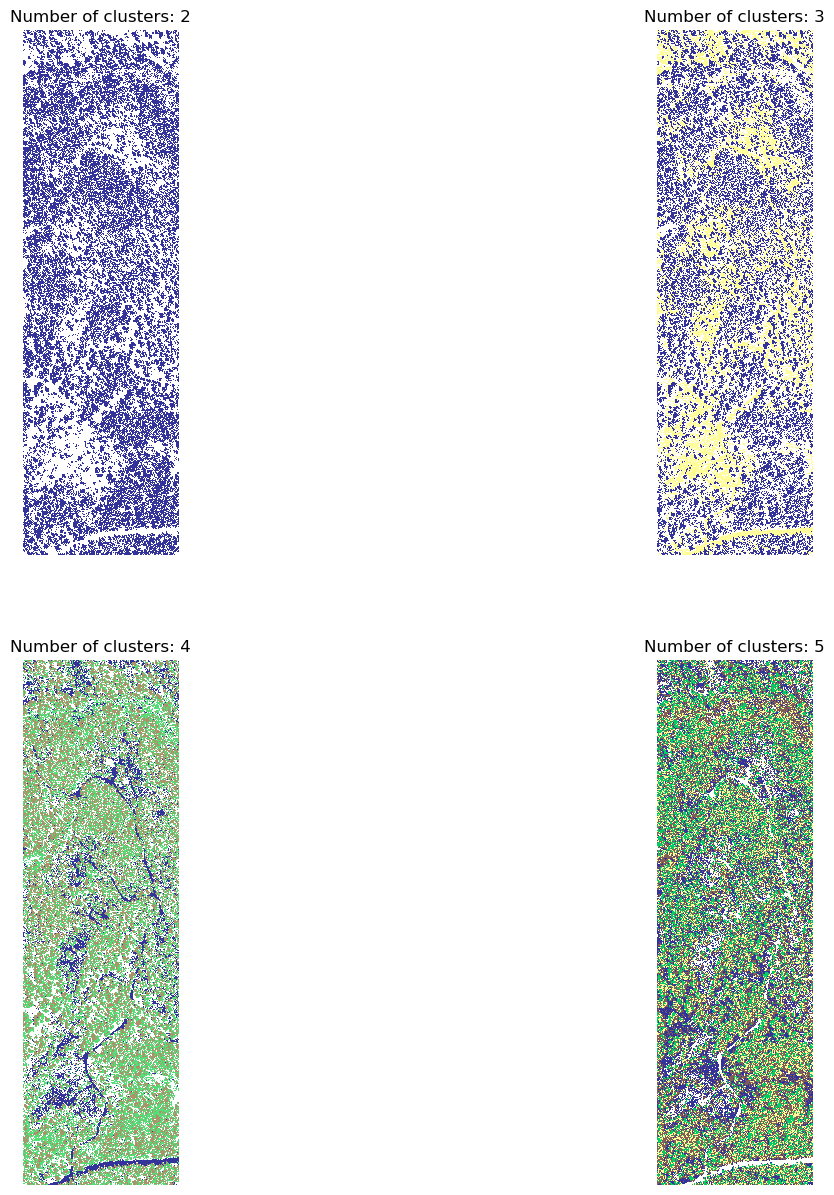

In [30]:
# Load the TIFF file
with rasterio.open(geotiff) as src:
    # Assuming bands 1 to 4 are RGB and NIR
    bands = [src.read(i) for i in range(1, 5)]
    image_data = np.dstack(bands)

# Prepare the data for clustering
pixels = image_data.reshape((-1, 4))  # Flatten the image data for clustering

# Dictionary to store predictions
predictions = {}

# Perform K-means clustering for 2 to n clusters
for k in range(2, 6): 
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    segmented_image = labels.reshape(image_data.shape[0], image_data.shape[1])
    predictions[k] = segmented_image

# Create a subplot grid and plot each clustering result
f, axes = plt.subplots(2, 2, figsize=(15, 15))  # Adjust subplot layout

for ax_i, (k, prediction) in enumerate(predictions.items()):
    if ax_i >= 6:
        continue
    ax = axes.flatten()[ax_i]
    im = ax.imshow(prediction, cmap="terrain", interpolation='none')
    ax.set_title("Number of clusters: " + str(k))
    ax.axis('off')  # Hide axis ticks

plt.show()

### K = 2

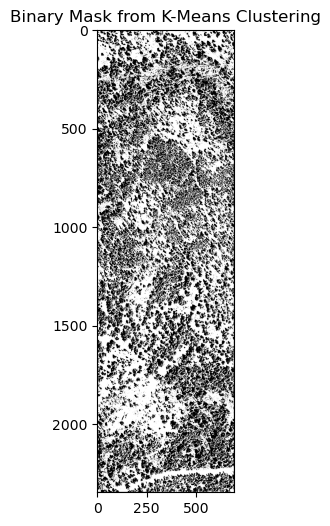

In [31]:
# Fit KMeans (k=2)
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(pixels)
cluster_labels = kmeans.labels_
clustered_image = cluster_labels.reshape(image_data.shape[:2])

# Create binary mask for a specific cluster (e.g., cluster 0)
binary_mask = (clustered_image == 0).astype(np.uint8) * 255
binary_mask = binary_mask == 0

# Display the binary mask
plt.figure(figsize=(10, 6))
plt.imshow(binary_mask, cmap='Greys')
plt.title('Binary Mask from K-Means Clustering')
plt.show()

# Save the binary mask as a GeoTIFF
array_to_image(binary_mask, 'kmeans-open-spaces.tif', source=geotiff)

# Segment Anything Model

Sources:
- https://github.com/facebookresearch/segment-anything
- https://github.com/opengeos/segment-geospatial

In [7]:
client = TileClient(geotiff)
t = get_leaflet_tile_layer(client)
m = Map(center=client.center(), zoom=client.default_zoom)
m.add(t)
m

Map(center=[40.2434655, -105.52648450000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom…

In [8]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint="sam_vit_h_4b8939.pth",
    sam_kwargs=None
)

In [9]:
mask = "segment-anything.tif"
sam.generate(
    geotiff, mask, batch=True, foreground=True, erosion_kernel=(3, 3), mask_multiplier=255
)

100%|██████████| 10/10 [14:08<00:00, 84.84s/it]


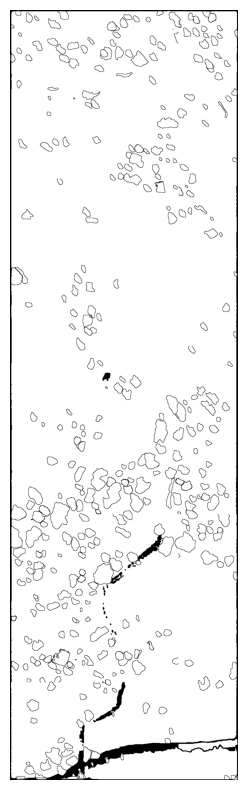

In [23]:
sam.show_masks(cmap="binary_r")